# King County Housing Sale Price Predictions

## The Business Problem

Phil and Nancy are partners own a house in King County and are looking to renovate their home in order to maximize the value of their home. They have some spare money and have come to the AA Consulting Agency to seek advice on what they should renovate in their house in order to maximize the resale value. They are looking to renovate their house with the intention of flipping it to make a profit and move into a bigger house somewhere else in King County. Our analysis is aimed to help them decide which features to renovate and by how much their home value will increase. Our statistical analysis is aimed to predict home price based on certain renovations. We will test which renovations have the biggest impact on price, and create a predictive model which can help them make an informed data-driven decision. 

This data was pulled from the King County government website and outlines home prices along with other features of the home in a csv file. We will be importing the file into two dateframes for use in the analysis. The data is generally clean, but contains zip codes from locations outside of King County, so we will be removing those as they are not relevant to the data. The address, lat, and long fields were gathered using a third party geocoding API, which explains why there was some discrepency. 

IMPORTS

In [48]:
import pandas as pd
pd.option_context('display.max_rows', None, 'display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
import sklearn.linear_model as lm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler,OneHotEncoder,OrdinalEncoder,
                                  PolynomialFeatures, PowerTransformer,
                                  FunctionTransformer)
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from itertools import chain, combinations
import warnings
warnings.filterwarnings(action='ignore')
sns.set_style('darkgrid')

%matplotlib inline

DATA

In [2]:
df = pd.read_csv('data/kc_house_data.csv', index_col=0) # (30155,25), 3 duplicated entries
print(f"Duplicates found and removed: * {df.loc[df.duplicated()].shape[0]} *")
df.drop_duplicates(inplace=True)

print("\nHEAD:")
display(df.head())

print("\nTAIL:")
display(df.tail())

print("\nINFO:")
df.info()

Duplicates found and removed: * 3 *

HEAD:


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
id,,,,,,,,,,,,,,,,,,,,,
7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,...,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,...,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591
1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,...,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520
1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,...,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020
8562780790,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,...,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188



TAIL:


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
id,,,,,,,,,,,,,,,,,,,,,
7834800180,11/30/2021,1555000.0,5,2.0,1910,4000,1.5,NO,NO,NO,...,PUBLIC,1600,1130,0,210,1921,0,"4673 Eastern Avenue North, Seattle, Washington...",47.664740,-122.32940
194000695,6/16/2021,1313000.0,3,2.0,2020,5800,2.0,NO,NO,NO,...,PUBLIC,2020,0,0,520,2011,0,"4131 44th Avenue Southwest, Seattle, Washingto...",47.565610,-122.38851
7960100080,5/27/2022,800000.0,3,2.0,1620,3600,1.0,NO,NO,YES,...,PUBLIC,940,920,240,110,1995,0,"910 Martin Luther King Jr Way, Seattle, Washin...",47.610395,-122.29585
2781280080,2/24/2022,775000.0,3,2.5,2570,2889,2.0,NO,NO,NO,...,PUBLIC,1830,740,480,100,2006,0,"17127 114th Avenue Southeast, Renton, Washingt...",47.449490,-122.18908
9557800100,4/29/2022,500000.0,3,1.5,1200,11058,1.0,NO,NO,NO,...,PUBLIC,1200,0,420,0,1965,0,"18615 7th Avenue South, Burien, Washington 981...",47.435840,-122.32634



INFO:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30152 entries, 7399300360 to 9557800100
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           30152 non-null  object 
 1   price          30152 non-null  float64
 2   bedrooms       30152 non-null  int64  
 3   bathrooms      30152 non-null  float64
 4   sqft_living    30152 non-null  int64  
 5   sqft_lot       30152 non-null  int64  
 6   floors         30152 non-null  float64
 7   waterfront     30152 non-null  object 
 8   greenbelt      30152 non-null  object 
 9   nuisance       30152 non-null  object 
 10  view           30152 non-null  object 
 11  condition      30152 non-null  object 
 12  grade          30152 non-null  object 
 13  heat_source    30120 non-null  object 
 14  sewer_system   30138 non-null  object 
 15  sqft_above     30152 non-null  int64  
 16  sqft_basement  30152 non-null  int64  
 17  sqft_garage    30152 non-null

# EDA

Column Names and Descriptions  
  for King County Data Set

* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `greenbelt` - Whether the house is adjacent to a green belt
* `nuisance` - Whether the house has traffic noise or other recorded nuisances
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each condition code
* `grade` - Overall grade of the house. Related to the construction and design of the house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
* `heat_source` - Heat source for the house
* `sewer_system` - Sewer system for the house
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `sqft_garage` - Square footage of garage space
* `sqft_patio` - Square footage of outdoor porch or deck space
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `address` - The street address
* `lat` - Latitude coordinate
* `long` - Longitude coordinate

## Target (Price) Analysis
We want to ensure normality in the target data as part of the assumtions for linear regression, so lets look at the log transformation of Price and Price with outliers removed.

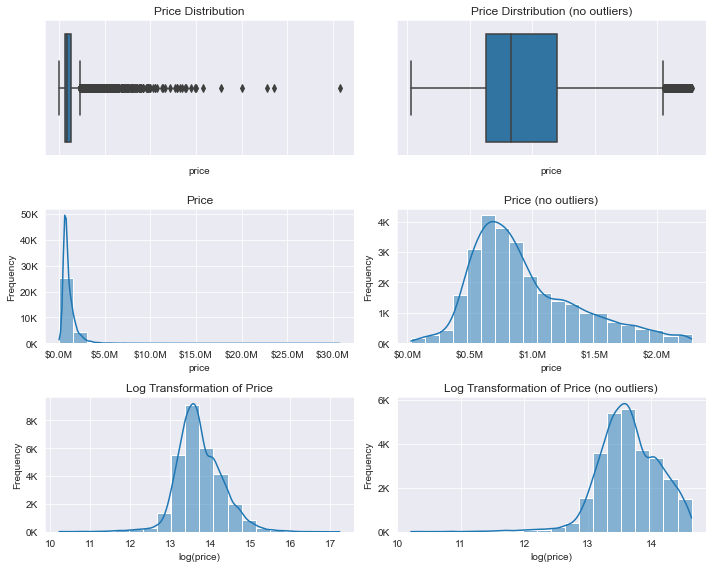

price outliers count: 1991


In [3]:
# Using Interquartile Range method to determine outliers
IQR = df['price'].quantile(.75) - df['price'].quantile(.25)
IQR_scaler = 1.5
price_outlier_u_bound = df['price'].quantile(.75) + IQR_scaler * IQR
price_outlier_l_bound = df['price'].quantile(.25) - IQR_scaler * IQR

# Series with outliers sliced off
price_no_outliers = df.loc[(df['price'] <= price_outlier_u_bound) & \
                           (df['price'] >= price_outlier_l_bound),'price']


fig, ax = plt.subplots(3,2, figsize = (10,8))
# boxplot of target
sns.boxplot(x=df['price'], ax=ax[0][0])
ax[0][0].set_title('Price Distribution')
ax[0][0].set_xticklabels([])

# boxplot of target - target_outliers
sns.boxplot(x=price_no_outliers, ax=ax[0][1])
ax[0][1].set_title('Price Dirstribution (no outliers)')
ax[0][1].set_xticklabels([])

# histogram of target
sns.histplot(df['price'], bins=20, kde=True, ax=ax[1][0])
ax[1][0].set_title('Price')
ax[1][0].set_ylabel('Frequency')
ax[1][0].set_xlabel('price')
formatter = ticker.FuncFormatter(lambda x, pos: '%1.0fK' % (x * 1e-3))
ax[1][0].yaxis.set_major_formatter(formatter)
formatter = ticker.FuncFormatter(lambda x, pos: '$%1.1fM' % (x * 1e-6))
ax[1][0].xaxis.set_major_formatter(formatter)

# histogram of target - target_outliers
sns.histplot(price_no_outliers, bins=20, kde=True, ax=ax[1][1])
ax[1][1].set_title('Price (no outliers)')
ax[1][1].set_ylabel('Frequency')
ax[1][1].set_xlabel('price')
formatter = ticker.FuncFormatter(lambda x, pos: '%1.0fK' % (x * 1e-3))
ax[1][1].yaxis.set_major_formatter(formatter)
formatter = ticker.FuncFormatter(lambda x, pos: '$%1.1fM' % (x * 1e-6))
ax[1][1].xaxis.set_major_formatter(formatter)

# histograms of log(target)
sns.histplot(np.log(df['price']), bins=20, kde=True, ax=ax[2][0])
ax[2][0].set_title('Log Transformation of Price')
ax[2][0].set_ylabel('Frequency')
ax[2][0].set_xlabel('log(price)')
formatter = ticker.FuncFormatter(lambda x, pos: '%1.0fK' % (x * 1e-3))
ax[2][0].yaxis.set_major_formatter(formatter)

# histograms of log(target - target_outliers)
sns.histplot(np.log(price_no_outliers), bins=20, kde=True, ax=ax[2][1])
ax[2][1].set_title('Log Transformation of Price (no outliers)')
ax[2][1].set_ylabel('Frequency')
ax[2][1].set_xlabel('log(price)')
formatter = ticker.FuncFormatter(lambda x, pos: '%1.0fK' % (x * 1e-3))
ax[2][1].yaxis.set_major_formatter(formatter)

# organize axes
plt.tight_layout()
# save fig to png
plt.savefig('imgs/price_outliers.png')
plt.show()
print('price outliers count: {}'.format(df.shape[0] - price_no_outliers.shape[0]))

Log(Price), Price_no_outliers and log(Price) have the most normal-like distributions.

### Price Normality
Lets look deeper on whether we should log transform price for linear regression

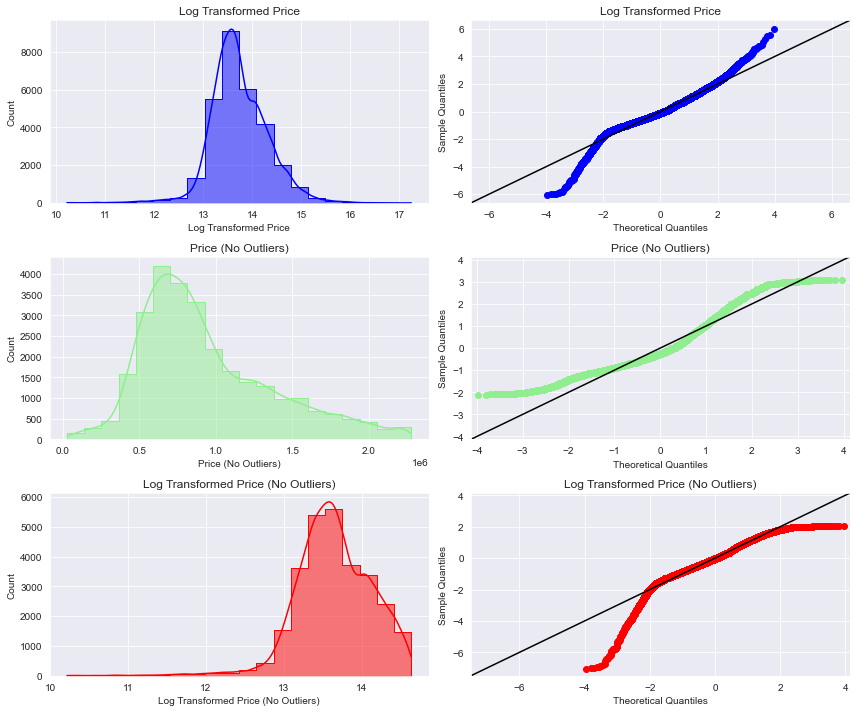

In [4]:
# Compare normality of target_no_outliers vs log_target_no_outliers

# Set up plot and properties of two targets
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,10))
targets = [np.log(df['price']), price_no_outliers, np.log(price_no_outliers)]
labels = ['Log Transformed Price', "Price (No Outliers)", "Log Transformed Price (No Outliers)"]
colors = ["blue", "lightgreen", 'red']

# Plot histograms
for index, ax in enumerate([axes[0][0],axes[1][0],axes[2][0]]):
    sns.histplot(targets[index], bins=20, element="step", kde=True, color=colors[index], ax=ax)
    ax.set_xlabel(labels[index])
    ax.set_title(labels[index])
    
# Plot Q-Q plots
for index, ax in enumerate([axes[0][1],axes[1][1],axes[2][1]]):
    sm.graphics.qqplot(targets[index], dist=stats.norm, line='45', fit=True, ax=ax)
    scatter = ax.lines[0]
    line = ax.lines[1]
    scatter.set_markeredgecolor(colors[index])
    scatter.set_markerfacecolor(colors[index])
    line.set_color("black")
    ax.set_title(labels[index])
    
fig.tight_layout()

From the qq-plots we can rank normality:
1. Log transformed price
2. Price without outliers
3. Log transformed price without outliers
  

# Numeric and Categorical Split
Splitting the dataframe into two for independant EDA

In [5]:
numeric_df = df.select_dtypes([int, float]).copy()
cat_df = df.select_dtypes(object)

## Numeric EDA

In [6]:
display(numeric_df.head())
display(numeric_df.describe(percentiles=[.05,.25,.5,.75,.95]))

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long
id,,,,,,,,,,,,,,
7399300360,675000.0,4,1.0,1180,7140,1.0,1180,0,0,40,1969,0,47.461975,-122.19052
8910500230,920000.0,5,2.5,2770,6703,1.0,1570,1570,0,240,1950,0,47.711525,-122.35591
1180000275,311000.0,6,2.0,2880,6156,1.0,1580,1580,0,0,1956,0,47.502045,-122.22520
1604601802,775000.0,3,3.0,2160,1400,2.0,1090,1070,200,270,2010,0,47.566110,-122.29020
8562780790,592500.0,2,2.0,1120,758,2.0,1120,550,550,30,2012,0,47.532470,-122.07188


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long
count,3.015200e+04,30152.000000,30152.000000,30152.000000,3.015200e+04,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000,30152.000000
mean,1.108029e+06,3.413571,2.334671,2112.408729,1.672492e+04,1.543380,1809.839347,476.010812,330.227414,217.396856,1975.159591,90.931348,47.328477,-121.319050
std,8.946277e+05,0.981653,0.889548,974.052997,6.038545e+04,0.567615,878.325182,579.635101,285.770425,245.309503,32.065976,416.492770,1.433181,5.722034
min,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,2.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,21.274240,-157.791480
5%,4.250000e+05,2.000000,1.000000,940.000000,1.196000e+03,1.000000,830.000000,0.000000,0.000000,0.000000,1916.000000,0.000000,47.261910,-122.386132
25%,6.480000e+05,3.000000,2.000000,1420.000000,4.850000e+03,1.000000,1180.000000,0.000000,0.000000,40.000000,1953.000000,0.000000,47.405361,-122.326050
50%,8.600000e+05,3.000000,2.500000,1920.000000,7.480000e+03,1.500000,1560.000000,0.000000,400.000000,150.000000,1977.000000,0.000000,47.551385,-122.225635
75%,1.300000e+06,4.000000,3.000000,2619.250000,1.057925e+04,2.000000,2270.000000,940.000000,510.000000,320.000000,2003.000000,0.000000,47.669911,-122.116236
95%,2.500000e+06,5.000000,4.000000,3890.000000,4.573800e+04,2.000000,3460.000000,1500.000000,780.000000,680.000000,2021.000000,0.000000,47.747316,-121.862909
max,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,12660.000000,8020.000000,3580.000000,4370.000000,2022.000000,2022.000000,64.824070,-70.074340


We can tell immediately that most columns have outliers

### Dropping Lat/Long

In [7]:
# We remove latitude and longitute columns, as they are implicitly determined by the zipcode categorical variable
numeric_df.drop(columns=['lat','long'], inplace=True)

# drop suspicious row with 4 bathrooms and bedrooms but no living space
display(numeric_df.loc[[1549500215], :])
numeric_df.drop(index=1549500215, inplace=True)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated
id,,,,,,,,,,,,
1549500215,1803000.0,4,4.0,3,326701,2.0,2,1,1,0,2021,0


### Heatmap
Now we check the pearson correlation between all the continuous numeric columns

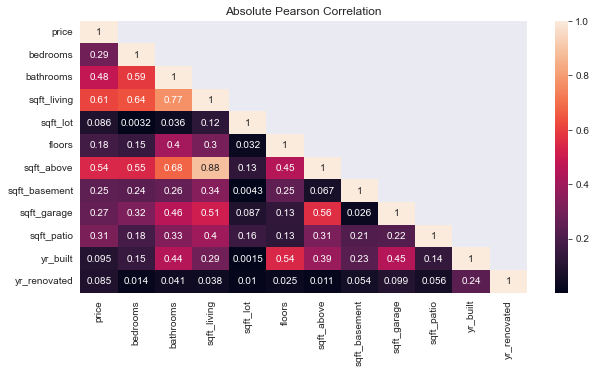

numeric abs(correlation) order: 
sqft_living      0.610040
sqft_above       0.540142
bathrooms        0.481183
sqft_patio       0.313659
bedrooms         0.290017
sqft_garage      0.265311
sqft_basement    0.245532
floors           0.179608
yr_built         0.095408
sqft_lot         0.085952
yr_renovated     0.085088
Name: price, dtype: float64


In [8]:
corr_df = numeric_df.corr().abs()

fig, ax = plt.subplots(figsize=(10,5))
sns.set_style('white')
mask = np.triu(np.ones_like(corr_df), k=1)
sns.heatmap(corr_df, annot=True, mask=mask, ax=ax).set(title='Absolute Pearson Correlation')

plt.show()
print("numeric abs(correlation) order: \n{}".format(corr_df['price'].sort_values(ascending=False)[1:]))

From the heatmap, we can see there is a high correlation between the square footage measurements.  Which will most likely violate the assumption of independance between the features for linear regression

### Home Square feet  
From our understanding of the data, sqft_living encompasses information from sqft_basement, sqft_patio, sqft_above and sqft_garage.  
We could keep only sqft_living, but instead we will make a new column: sqft_home, which is a linear combination of these correlated columns, weighted by their correlations with price. This way we can avoid multicolinearity while preserving most of the information between these columns. 
  
We will recalculate the weights in this process after train-test split to avoid Data Leakage

In [9]:
# Create Aggregate feature sqft_home
numeric_df["sqft_home"] = (.61*numeric_df['sqft_living'] + \
                           .54*numeric_df['sqft_above'] + \
                           .25*numeric_df['sqft_basement'] + \
                           .27*numeric_df['sqft_garage'] + \
                           .31*numeric_df['sqft_patio'])

### PairPlots
Now lets plot all numeric features against each other to vizualize their correlations, paying specific attention to price.  
With seaborn's pairplot we can also check normality of the feature distributions and homoscedasticity.

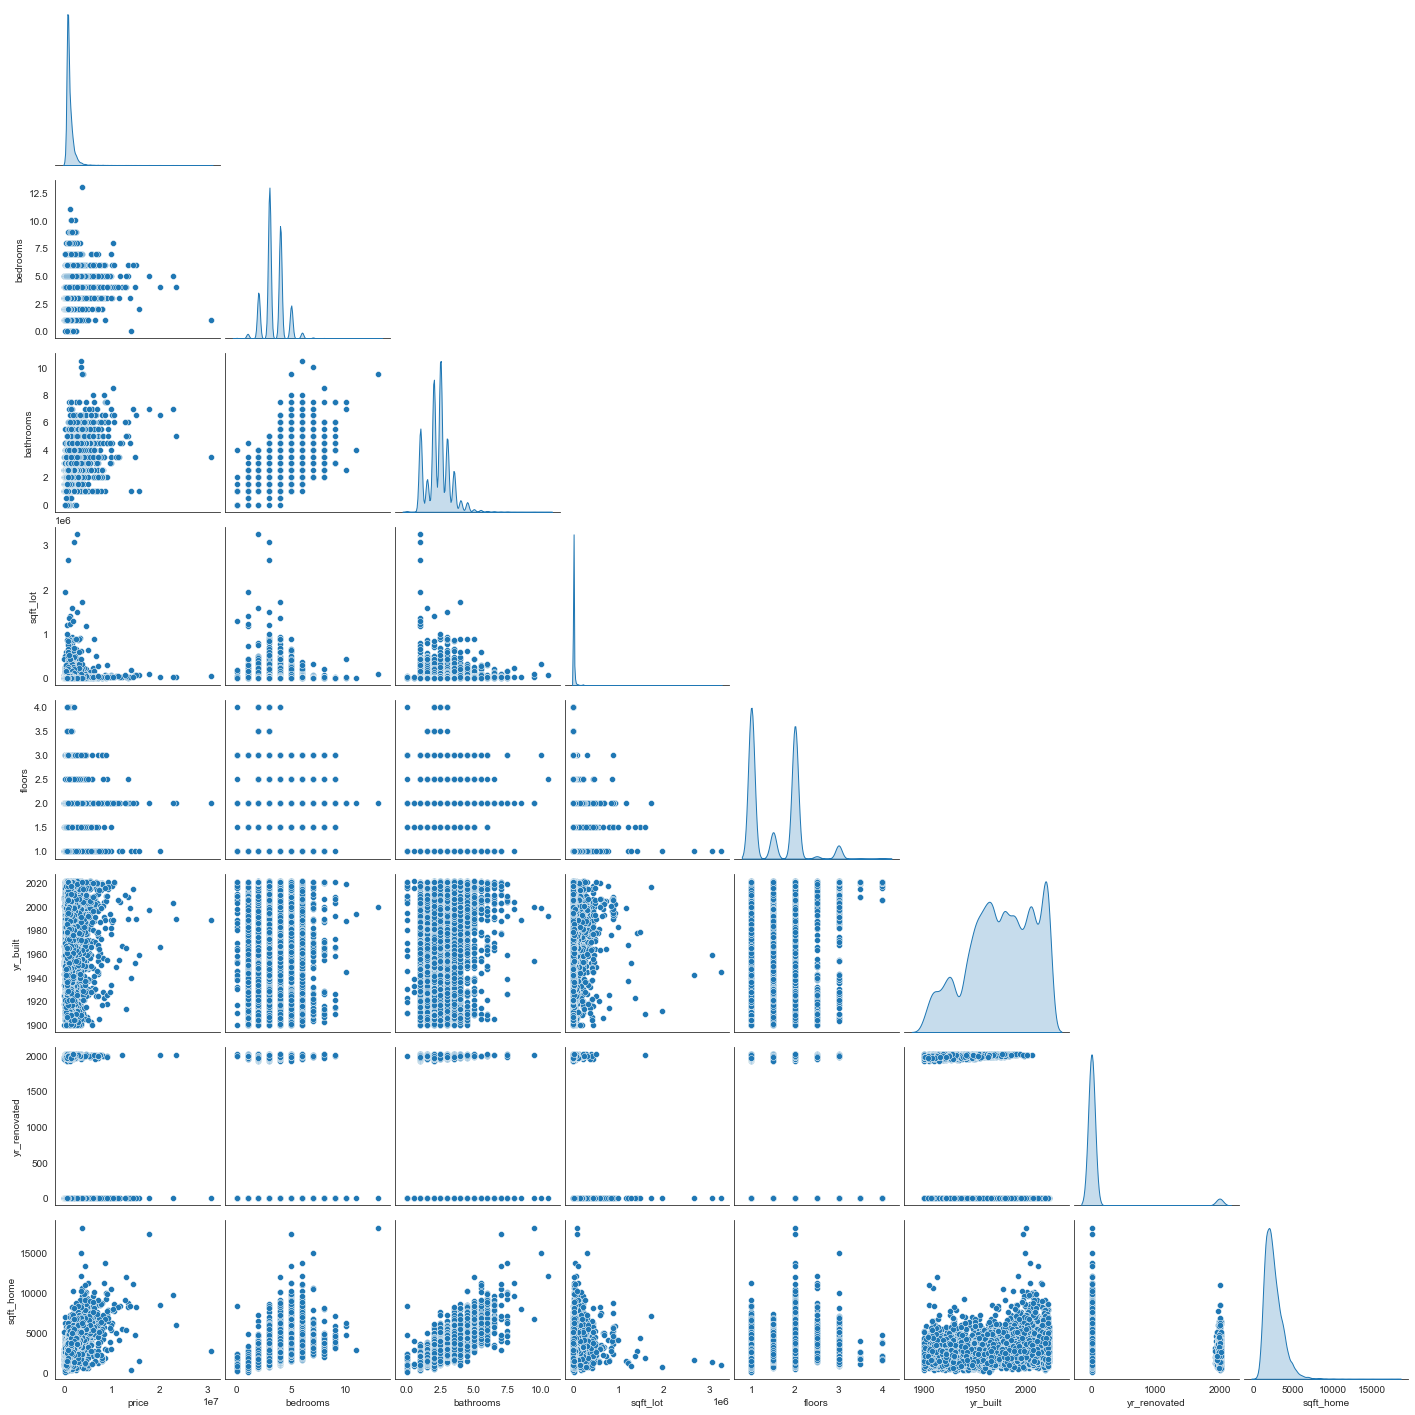

In [10]:
# plot only lower triangle due to symmetry
sns.pairplot(numeric_df.drop(columns=['sqft_living','sqft_above','sqft_basement','sqft_garage','sqft_patio']), 
             corner=True, 
             diag_kind='kde')
plt.show()

### Removing outliers for skewed Numeric features
'sqft_home', 'sqft_lot', 'bedrooms', 'bathrooms' and 'floors' have concerning outliers, and their plots against price seems heteroscedatic, showing variability in the predictive capability of these features at large values.

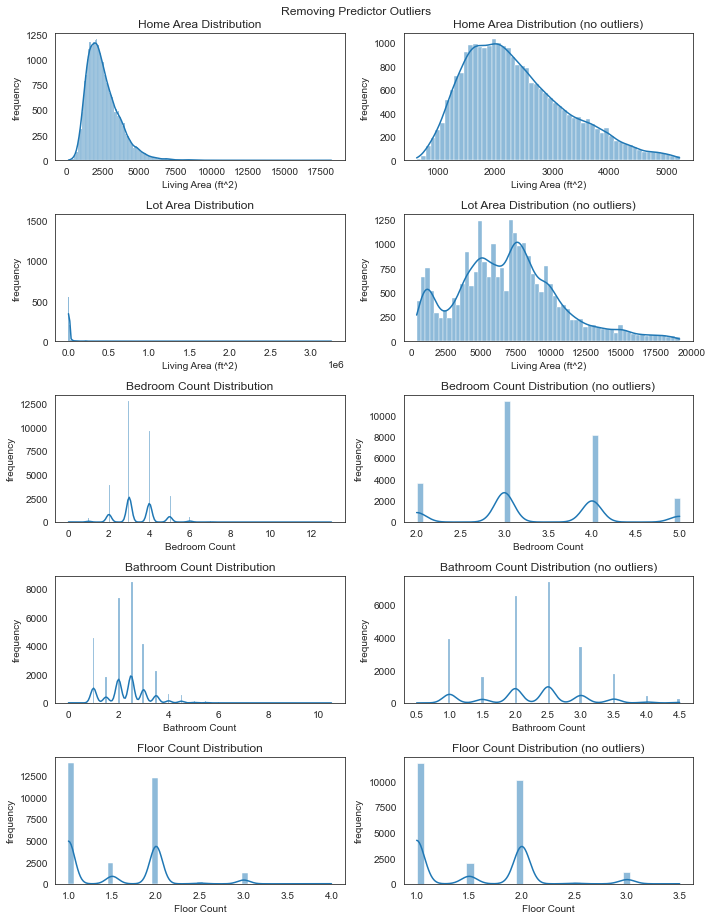

In [11]:
# remove outliers from features
outlier_features = ['sqft_home', 'sqft_lot', 'bedrooms', 'bathrooms', 'floors']
outlier_u_bound = {}
outlier_l_bound = {}
# df to modify and compare with numeric_df
outlier_df = numeric_df.copy()

# calculate outlier bounds with Inter Quartile Range Method on X_train
for col in outlier_features:
    IQR = numeric_df[col].quantile(.75) - numeric_df[col].quantile(.25)
    IQR_scaler = 1.5
    outlier_u_bound[col] = numeric_df[col].quantile(.75) + IQR_scaler * IQR
    outlier_l_bound[col] = numeric_df[col].quantile(.25) - IQR_scaler * IQR

# slice out outliers from data
for col in outlier_features:
    outlier_df = outlier_df.loc[(outlier_df[col] <= outlier_u_bound[col]) &\
                                (outlier_df[col] >= outlier_l_bound[col])]

# setup axes and seaborn plot background
fig, ax = plt.subplots(nrows=len(outlier_features), ncols=2, figsize=(10,13))
sns.set_style('darkgrid')


# title for the entire figure
fig.suptitle('Removing Predictor Outliers')

# data and label iterables for graphing in a loop
data = [numeric_df, outlier_df]
titles = [['Home Area Distribution', 'Home Area Distribution (no outliers)'],
        ['Lot Area Distribution', 'Lot Area Distribution (no outliers)'],
        ['Bedroom Count Distribution', 'Bedroom Count Distribution (no outliers)'],
        ['Bathroom Count Distribution', 'Bathroom Count Distribution (no outliers)'],
        ['Floor Count Distribution','Floor Count Distribution (no outliers)']]
xlabels = ['Living Area (ft^2)','Living Area (ft^2)','Bedroom Count','Bathroom Count','Floor Count']

# Side by side comparisons of the feature distributions before and after removing outliers
for row in range(len(outlier_features)):
    for col in range(2):
        sns.histplot(x=outlier_features[row], data=data[col], kde=True, bins='auto', ax=ax[row][col])
        ax[row][col].set_xlabel(xlabels[row])
        ax[row][col].set_ylabel('frequency')
        ax[row][col].set_title(titles[row][col])


plt.tight_layout()

plt.savefig('imgs/feature_outliers_all.png')
plt.show()

In [12]:
# check for clean numeric data
numeric_df.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
sqft_above       0
sqft_basement    0
sqft_garage      0
sqft_patio       0
yr_built         0
yr_renovated     0
sqft_home        0
dtype: int64

# Categorical EDA

In [13]:
cat_df.head()

,date,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,address
id,,,,,,,,,,
7399300360,5/24/2022,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,"2102 Southeast 21st Court, Renton, Washington ..."
8910500230,12/13/2021,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,"11231 Greenwood Avenue North, Seattle, Washing..."
1180000275,9/29/2021,NO,NO,NO,AVERAGE,Average,7 Average,Gas,PUBLIC,"8504 South 113th Street, Seattle, Washington 9..."
1604601802,12/14/2021,NO,NO,NO,AVERAGE,Average,9 Better,Gas,PUBLIC,"4079 Letitia Avenue South, Seattle, Washington..."
8562780790,8/24/2021,NO,NO,YES,NONE,Average,7 Average,Electricity,PUBLIC,"2193 Northwest Talus Drive, Issaquah, Washingt..."


## Ordinal Encoding
We need the labels to be numbers so we will encode in their proper orders

In [14]:

oe_cols = ['view', 'condition', 'grade', 'waterfront','greenbelt', 'nuisance']
oe_orders = [['NONE','FAIR','AVERAGE','GOOD','EXCELLENT'],
            ['Poor','Fair','Average','Good','Very Good'],
            ['1 Cabin',
            '2 Substandard',
            '3 Poor',
            '4 Low',
            '5 Fair',
            '6 Low Average',
            '7 Average',
            '8 Good',
            '9 Better',
            '10 Very Good',
            '11 Excellent',
            '12 Luxury',
            '13 Mansion'],
            ['NO','YES'],
            ['NO','YES'],
            ['NO','YES']]

for col, order in zip(oe_cols,oe_orders):
    cat_df[col] = OrdinalEncoder([order]).fit_transform(cat_df[[col]])
cat_df.head()


,date,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,address
id,,,,,,,,,,
7399300360,5/24/2022,0.0,0.0,0.0,0.0,3.0,6.0,Gas,PUBLIC,"2102 Southeast 21st Court, Renton, Washington ..."
8910500230,12/13/2021,0.0,0.0,1.0,2.0,2.0,6.0,Oil,PUBLIC,"11231 Greenwood Avenue North, Seattle, Washing..."
1180000275,9/29/2021,0.0,0.0,0.0,2.0,2.0,6.0,Gas,PUBLIC,"8504 South 113th Street, Seattle, Washington 9..."
1604601802,12/14/2021,0.0,0.0,0.0,2.0,2.0,8.0,Gas,PUBLIC,"4079 Letitia Avenue South, Seattle, Washington..."
8562780790,8/24/2021,0.0,0.0,1.0,0.0,2.0,6.0,Electricity,PUBLIC,"2193 Northwest Talus Drive, Issaquah, Washingt..."


## Zipcode Encoding
The zipcode in the address will be a useful feature, so we will one hot encode them  
We keep only the data in King County

In [15]:
# King County Zipcodes
# https://www.ciclt.net/sn/clt/capitolimpact/gw_ziplist.aspx?FIPS=53033
ci_zips = ['98002 (Auburn)', '98092 (Auburn)', '98224 (Baring)', '98004 (Bellevue)', '98005 (Bellevue)', '98006 (Bellevue)', '98007 (Bellevue)', '98008 (Bellevue)', '98010 (Black Diamond)', '98011 (Bothell)', '98178 (Bryn Mawr-Skyway)', '98148 (Burien)', '98166 (Burien)', '98014 (Carnation)', '98077 (Cottage Lake)', '98042 (Covington)', '98198 (Des Moines)', '98019 (Duvall)', '98031 (East Hill-Meridian)', '98022 (Enumclaw)', '98058 (Fairwood)', '98024 (Fall City)', '98003 (Federal Way)', '98023 (Federal Way)', '98027 (Issaquah)', '98029 (Issaquah)', '98028 (Kenmore)', '98032 (Kent)', '98030 (Kent)', '98033 (Kirkland)', '98034 (Kirkland)', '98001 (Lakeland North)', '98038 (Maple Valley)', '98039 (Medina)', '98040 (Mercer Island)', '98045 (North Bend)', '98047 (Pacific)', '98050 (Preston)', '98051 (Ravensdale)', '98052 (Redmond)', '98055 (Renton)', '98056 (Renton)', '98057 (Renton)', '98059 (Renton)', '98074 (Sammamish)', '98075 (Sammamish)', '98188 (SeaTac)', '98199 (Seattle)', '98174 (Seattle)', '98154 (Seattle)', '98158 (Seattle)', '98164 (Seattle)', '98101 (Seattle)', '98102 (Seattle)', '98103 (Seattle)', '98104 (Seattle)', '98105 (Seattle)', '98106 (Seattle)', '98107 (Seattle)', '98108 (Seattle)', '98109 (Seattle)', '98112 (Seattle)', '98115 (Seattle)', '98116 (Seattle)', '98117 (Seattle)', '98118 (Seattle)', '98119 (Seattle)', '98121 (Seattle)', '98122 (Seattle)', '98125 (Seattle)', '98126 (Seattle)', '98133 (Seattle)', '98134 (Seattle)', '98136 (Seattle)', '98144 (Seattle)', '98155 (Shoreline)', '98177 (Shoreline)', '98288 (Skykomish)', '98065 (Snoqualmie)', '98168 (Tukwila)', '98053 (Union Hill-Novelty Hill)', '98195 (Univ Of Washington)', '98070 (Vashon)', '98146 (White Center)', '98072 (Woodinville)']
ci_zips = set([x.split()[0] for x in ci_zips])

# strip zipcode from address and populate new columns 'zipcode', if zipcode not in King county, set to nan
cat_df['zipcode'] = [address.split(',')[-2][-5:] for address in cat_df['address']]
cat_df['zipcode'] = cat_df['zipcode'].apply(lambda x: x if x in ci_zips else np.nan)
cat_df.dropna(inplace=True)

# columns to one-hot encode
ohe_cols_preprocessed = ['heat_source','sewer_system','zipcode']

# Set up encoder, dropping the first column after processing for: Degrees of freedom = 1
ohe = OneHotEncoder(sparse = False, drop='first')
ohe.fit(cat_df[ohe_cols_preprocessed])
ohe_cols = ohe.get_feature_names()

# Excecute transformation
cat_df[ohe_cols] = ohe.transform(cat_df[ohe_cols_preprocessed])

# Drop old columns
cat_df.drop(columns=ohe_cols_preprocessed + ['address', 'date'], inplace=True)

cat_df.head()

,waterfront,greenbelt,nuisance,view,condition,grade,x0_Electricity/Solar,x0_Gas,x0_Gas/Solar,x0_Oil,...,x2_98155,x2_98166,x2_98168,x2_98177,x2_98178,x2_98188,x2_98198,x2_98199,x2_98224,x2_98288
id,,,,,,,,,,,,,,,,,,,,,
7399300360,0.0,0.0,0.0,0.0,3.0,6.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8910500230,0.0,0.0,1.0,2.0,2.0,6.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1180000275,0.0,0.0,0.0,2.0,2.0,6.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1604601802,0.0,0.0,0.0,2.0,2.0,8.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8562780790,0.0,0.0,1.0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# sanity check for and drop nulls
display(cat_df.isna().sum().sum())
cat_df.dropna(inplace=True)

0

# Helper Functions
Defining useful scoring and printing functions

In [17]:
def get_train_score(xtrain, ytrain):
    """
    create sklearn linear model and return the R2 score on training data
    params:
        xtrain -> array of shape (sample_size, num_features)
        ytrain -> array of shape (sample_size, num_targets)
    returns:
        float R2 score of training linear regression
    """
    lr = lm.LinearRegression()
    lr.fit(xtrain, ytrain)
    return lr.score(xtrain, ytrain)

def get_adjusted_train_score(xtrain, ytrain):
    """
    create sklearn linear model and return the adjusted R2 score on training data
    params:
        xtrain -> array of shape (sample_size, num_features)
        ytrain -> array of shape (sample_size, num_targets)
    returns:
        float Adjusted R2 score of training linear regression
    """
    R2 = get_train_score(xtrain,ytrain)
    # number of observations in train data
    n = xtrain.shape[0]
    # number of features in train data (including constant)
    k = xtrain.shape[1] + 1
    return 1 - ( (1-R2) * ( (n-1)/(n-k-1 ) ) )

def get_test_score(xtrain, ytrain, xtest, ytest):
    """
    create sklearn linear model and return the R2 score on test data
    params:
        xtrain -> array of shape (sample_size, num_features)
        ytrain -> array of shape (sample_size, num_targets)
        xtest -> array of shape (sample_size, num_features)
        ytest -> array of shape (sample_size, num_targets)
    returns:
        float R2 score of test data from linear regression
    """
    lr = lm.LinearRegression()
    lr.fit(xtrain, ytrain)
    return lr.score(xtest, ytest)

def get_adjusted_test_score(xtrain, ytrain, xtest, ytest):
    """
    create sklearn linear model and return the adjustec R2 score on test data
    params:
        xtrain -> array of shape (sample_size, num_features)
        ytrain -> array of shape (sample_size, num_targets)
        xtest -> array of shape (sample_size, num_features)
        ytest -> array of shape (sample_size, num_targets)
    returns:
        float adjusted R2 score of test data from linear regression
    """
    R2 = get_test_score(xtrain,ytrain,xtest,ytest)
    # number of observations in test data
    n = xtest.shape[0]
    # number of features in test data (including constant)
    k = xtest.shape[1] + 1
    return 1 - ( (1-R2) * ( (n-1)/(n-k-1 ) ) )

def print_train_scores(xtrain, ytrain):
    # Print train data R2 and ajusted R2 in sequence
    print(f"         Train R2: {get_train_score(xtrain, ytrain)}")
    print(f"Train Adjusted R2: {get_train_score(xtrain, ytrain)}")

def print_test_scores(xtrain, ytrain, xtest, ytest):
    # Print test data R2 and ajusted R2 in sequence
    print(f"          Test R2: {get_test_score(xtrain, ytrain, xtest, ytest)}")
    print(f" Test Adjusted R2: {get_test_score(xtrain, ytrain, xtest, ytest)}")

def print_errors(pred, ytest):
    # print Mean Squared, Root Mean Squared and Absolute Error
    print("              MSE:",metrics.mean_squared_error(ytest, pred)) 
    print("             RMSE:",metrics.mean_squared_error(ytest, pred,squared=False) )
    print("              MAE:",metrics.mean_absolute_error(ytest, pred))

def print_stats(res):
    # print condition number
    print(f"Condition Number: {res.condition_number}")


# Combine and Train Test Split

In [18]:
# joining numeric and categorical features by index
clean_df = numeric_df.join(cat_df, how='inner')
clean_outlier_df = outlier_df.join(cat_df, how='inner')

# numeric Train test split (.75 train, .25 test)
X_train, X_test, y_train, y_test = \
    train_test_split(clean_df.drop(columns='price'), 
                     clean_df[['price']], 
                     test_size=.25, 
                     random_state=42)

print(f"Train/Test X shapes: {X_train.shape}, {X_test.shape}")
print(f"Train/Test y shapes: {y_train.shape}, {y_test.shape}\n\nColumns:")
print(f"clean_df\n{np.array(clean_df.columns.to_list())}")

Train/Test X shapes: (21860, 102), (7287, 102)
Train/Test y shapes: (21860, 1), (7287, 1)

Columns:
clean_df
['price' 'bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot' 'floors'
 'sqft_above' 'sqft_basement' 'sqft_garage' 'sqft_patio' 'yr_built'
 'yr_renovated' 'sqft_home' 'waterfront' 'greenbelt' 'nuisance' 'view'
 'condition' 'grade' 'x0_Electricity/Solar' 'x0_Gas' 'x0_Gas/Solar'
 'x0_Oil' 'x0_Oil/Solar' 'x0_Other' 'x1_PRIVATE RESTRICTED' 'x1_PUBLIC'
 'x1_PUBLIC RESTRICTED' 'x2_98002' 'x2_98003' 'x2_98004' 'x2_98005'
 'x2_98006' 'x2_98007' 'x2_98008' 'x2_98010' 'x2_98011' 'x2_98014'
 'x2_98019' 'x2_98022' 'x2_98023' 'x2_98024' 'x2_98027' 'x2_98028'
 'x2_98029' 'x2_98030' 'x2_98031' 'x2_98032' 'x2_98033' 'x2_98034'
 'x2_98038' 'x2_98039' 'x2_98040' 'x2_98042' 'x2_98045' 'x2_98047'
 'x2_98050' 'x2_98051' 'x2_98052' 'x2_98053' 'x2_98055' 'x2_98056'
 'x2_98057' 'x2_98058' 'x2_98059' 'x2_98065' 'x2_98070' 'x2_98072'
 'x2_98074' 'x2_98075' 'x2_98077' 'x2_98092' 'x2_98102' 'x2_98103'
 'x2_9810

# Intercept only model
For Initial comparison, a model that predicts the average of y_train

In [19]:
# set X to mean(y_train)
y = y_train.copy()
X = np.array([y['price'].mean()] * len(y)).reshape(-1,1)
ytest = y_test.copy()
xtest = np.array([y['price'].mean()] * len(y_test)).reshape(-1,1)

# Use sklearn to get R2 results and metrics
lr = lm.LinearRegression()
lr.fit(X,y)
print_train_scores(X,y)
print_errors(lr.predict(xtest),ytest)

         Train R2: 0.0
Train Adjusted R2: 0.0
              MSE: 746232505051.7286
             RMSE: 863847.5010392335
              MAE: 526591.703061393


# Regressive Model Iterations

## Baseline Model
For a baseline model, we will score the numeric feature with highest correlation with price on unseen data X_test

In [20]:
X = X_train[['sqft_home']].copy()
xtest = X_test[['sqft_home']].copy()

y, ytest = y_train.copy(), y_test.copy()

# sklearn
lr = lm.LinearRegression()
lr.fit(X, y_train)
print("Train R2:", get_train_score(X, y))
print("Train Adjusted R2:", get_adjusted_train_score(X, y))
print_test_scores(X, y, xtest[['sqft_home']], ytest)
print_errors(lr.predict(xtest), ytest)

# print model statistics
results = sm.OLS(y_train,sm.add_constant(X)).fit()
print_stats(results)

Train R2: 0.38912017997934834
Train Adjusted R2: 0.3890642821141317
          Test R2: 0.3518565444743025
 Test Adjusted R2: 0.3518565444743025
              MSE: 483574265611.467
             RMSE: 695395.0428436105
              MAE: 403638.722185664
Condition Number: 6883.092953416579


## Regression Model 1
Use all the numeric and categorical features

In [21]:
X, xtest = X_train.copy(), X_test.copy()
y, ytest = y_train.copy(), y_test.copy()

# sklearn
lr = lm.LinearRegression()
lr.fit(X, y)
print_train_scores(X, y)
print_test_scores(X, y, xtest, ytest)
print_errors(lr.predict(xtest),ytest)

# statstics data
results = sm.OLS(y_train,sm.add_constant(X)).fit()
print_stats(results)


         Train R2: 0.6603394245872392
Train Adjusted R2: 0.6603394245872392
          Test R2: 0.6473374287937927
 Test Adjusted R2: 0.6473374287937927
              MSE: 263118515547.41473
             RMSE: 512950.79252050555
              MAE: 262639.1301189698
Condition Number: 1.8514570307466122e+17


There was an increase in R2 from the basemodel, although the extreme multicolinearity suggests we should scale the features

## Regression Model 2
We will use all the numeric and categorical features and Standard Scale them

In [22]:
scale_cols = clean_df.drop(columns='price').columns.to_list()

#print scale_cols
np.array(scale_cols)

array(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio',
       'yr_built', 'yr_renovated', 'sqft_home', 'waterfront', 'greenbelt',
       'nuisance', 'view', 'condition', 'grade', 'x0_Electricity/Solar',
       'x0_Gas', 'x0_Gas/Solar', 'x0_Oil', 'x0_Oil/Solar', 'x0_Other',
       'x1_PRIVATE RESTRICTED', 'x1_PUBLIC', 'x1_PUBLIC RESTRICTED',
       'x2_98002', 'x2_98003', 'x2_98004', 'x2_98005', 'x2_98006',
       'x2_98007', 'x2_98008', 'x2_98010', 'x2_98011', 'x2_98014',
       'x2_98019', 'x2_98022', 'x2_98023', 'x2_98024', 'x2_98027',
       'x2_98028', 'x2_98029', 'x2_98030', 'x2_98031', 'x2_98032',
       'x2_98033', 'x2_98034', 'x2_98038', 'x2_98039', 'x2_98040',
       'x2_98042', 'x2_98045', 'x2_98047', 'x2_98050', 'x2_98051',
       'x2_98052', 'x2_98053', 'x2_98055', 'x2_98056', 'x2_98057',
       'x2_98058', 'x2_98059', 'x2_98065', 'x2_98070', 'x2_98072',
       'x2_98074', 'x2_98075', 'x2_98077

In [23]:
X, xtest = X_train.copy(), X_test.copy()
y, ytest = y_train.copy(), y_test.copy()

# scale the features to have a mean of 0 and standard deviation of 1
scaler = StandardScaler().fit(X)
X[scale_cols], xtest[scale_cols] = scaler.transform(X), scaler.transform(xtest)

# sklearn
lr = lm.LinearRegression()
lr.fit(X, y)
print_train_scores(X, y)
print_test_scores(X, y, xtest, ytest)
print_errors(lr.predict(xtest),ytest)

# statstics data
results = sm.OLS(y_train,sm.add_constant(X)).fit()
print_stats(results)


         Train R2: 0.6603395424433508
Train Adjusted R2: 0.6603395424433508
          Test R2: 0.6473240905020876
 Test Adjusted R2: 0.6473240905020876
              MSE: 263128467132.30054
             RMSE: 512960.49275972566
              MAE: 262655.7777069954
Condition Number: 2295809634200880.0


Scaling the features had no effect on the R2, but reduced some multicolinearity.

## Regression Model 3
In our EDA we saw that log('price') had the most normal distribution, so we will implement that

In [24]:
X, xtest = X_train.copy(), X_test.copy()
y, ytest = np.log(y_train.copy()), np.log(y_test.copy())

# scale the features to have a mean of 0 and standard deviation of 1
scaler = StandardScaler().fit(X)
X[scale_cols], xtest[scale_cols] = scaler.transform(X), scaler.transform(xtest)

# sklearn
lr = lm.LinearRegression()
lr.fit(X, y)
print_train_scores(X, y)
print_test_scores(X, y, xtest, ytest)
# inverse log transform to see Errors in $ Dollar units
print_errors(np.exp(lr.predict(xtest)),np.exp(ytest))

# statstics data
results = sm.OLS(y_train,sm.add_constant(X)).fit()
print_stats(results)

         Train R2: 0.7101373438015719
Train Adjusted R2: 0.7101373438015719
          Test R2: 0.6939157650664806
 Test Adjusted R2: 0.6939157650664806
              MSE: 437244083108.2394
             RMSE: 661244.3444810997
              MAE: 220193.2860215568
Condition Number: 2295809634200880.0


We can see that following the normality assumptions of linear regression has an effect on its predictive power.  
We should take that one step further and apply the outlier removal we observed in EDA.  
Now, to deal with the high multicolinearity, we should remove the features whos information is encapsulated by our 'sqft_home' feature.


## Regression Model 4
Removing dependant features and feature outliers

In [25]:
clean_outlier_df.drop(columns=['sqft_living','sqft_above','sqft_basement','sqft_garage','sqft_patio'], inplace=True)
scale_cols = clean_outlier_df.drop(columns='price').columns.to_list()

In [26]:
# Train test splitting from dataframe with feature's outliers removed
X_train, X_test, y_train, y_test = train_test_split(clean_outlier_df.drop(columns=['price']), 
                                                    clean_outlier_df[['price']],
                                                    test_size=.25,
                                                    random_state=42)

X, xtest = X_train.copy(), X_test.copy()
y, ytest = np.log(y_train.copy()), np.log(y_test.copy())

# scale the features to have a mean of 0 and standard deviation of 1
scaler = StandardScaler().fit(X)
X[scale_cols], xtest[scale_cols] = scaler.transform(X), scaler.transform(xtest)

# sklearn
lr = lm.LinearRegression()
lr.fit(X, y)
print_train_scores(X, y)
print_test_scores(X, y, xtest, ytest)
print_errors(np.exp(lr.predict(xtest)),np.exp(ytest))

# statstics data
results = sm.OLS(y_train,sm.add_constant(X)).fit()
print_stats(results)

         Train R2: 0.6972597421880891
Train Adjusted R2: 0.6972597421880891
          Test R2: 0.6832713611282084
 Test Adjusted R2: 0.6832713611282084
              MSE: 90784167606.39491
             RMSE: 301304.1114993204
              MAE: 177201.50710497578
Condition Number: 3.7225381428801965e+17


Unfortunately, that didn't seem to help our R2

## Regression Model 5
Using no outlier price instead of log transformed price

In [27]:
# remove target outliers from clean_outlier_df
# Using Interquartile Range method to determine outliers
IQR = df['price'].quantile(.75) - df['price'].quantile(.25)
IQR_scaler = 1.5
price_outlier_u_bound = df['price'].quantile(.75) + IQR_scaler * IQR
price_outlier_l_bound = df['price'].quantile(.25) - IQR_scaler * IQR

# Series with outliers sliced off
clean_outlier_df = clean_outlier_df.loc[(clean_outlier_df['price'] <= price_outlier_u_bound) & \
                                        (clean_outlier_df['price'] >= price_outlier_l_bound)]

# Train test splitting from dataframe with feature's outliers removed
X_train, X_test, y_train, y_test = train_test_split(clean_outlier_df.drop(columns='price'), 
                                                    clean_outlier_df[['price']],
                                                    test_size=.25,
                                                    random_state=42)

X, xtest = X_train.copy(), X_test.copy()
y, ytest = y_train.copy(), y_test.copy()

# scale the features to have a mean of 0 and standard deviation of 1
scaler = StandardScaler().fit(X)
X[scale_cols], xtest[scale_cols] = scaler.transform(X), scaler.transform(xtest)

# sklearn
lr = lm.LinearRegression()
lr.fit(X, y)
print_train_scores(X, y)
print_test_scores(X, y, xtest, ytest)
print_errors(lr.predict(xtest),ytest)

# statstics data
results = sm.OLS(y_train,sm.add_constant(X)).fit()
print_stats(results)

         Train R2: 0.721615832570706
Train Adjusted R2: 0.721615832570706
          Test R2: 0.723048626563473
 Test Adjusted R2: 0.723048626563473
              MSE: 49631570962.6705
             RMSE: 222781.44214155385
              MAE: 159140.2116252196
Condition Number: 4481280365648220.5


### Checking VIF
Our predictor has improved although the condition number still indicates high multicolinearity,

In [28]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns.to_list()
# calculating VIF for each feature
vif_data["VIF"] = [VIF(X.values, i) for i in range(X.shape[1])]
# get regression coefficients from linear model
vif_data['coef_'] = pd.Series(lr.coef_.flatten())
# get pvals from statsmodel results, exclude const
vif_data['pval'] = results.pvalues.to_list()[1:]
# sort the dataframe to see the features with highest variance inflation
vif_data.sort_values(by='VIF', ascending=False, inplace=True)

# show all 20 rows
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(vif_data.head(20))

,feature,VIF,coef_,pval
6,sqft_home,4.119887,163621.819372,0.000000e+00
4,yr_built,3.457281,-18551.862233,4.720611e-09
12,grade,2.801636,73160.971207,1.139674e-142
1,bathrooms,2.768567,8126.657308,4.122695e-03
67,x2_98103,2.670590,92746.774388,3.637941e-236
76,x2_98117,2.575255,91389.232782,1.023359e-237
74,x2_98115,2.552052,94630.681144,1.811446e-256
47,x2_98042,2.490493,2179.261355,4.212566e-01
44,x2_98038,2.314458,17352.518688,2.144754e-11
2,sqft_lot,2.306730,20597.560222,1.761685e-15


The VIF's for all features are good, < 5.

## Final Regression Model Showing all steps
Increase Dimentionality by including polynomial features for all columns except one_hot encoded

In [29]:
df = pd.read_csv('data/kc_house_data.csv', index_col=0) # (30155,25), 3 duplicated entries
# display(df.loc[df.duplicated(keep=False)])
df.drop_duplicates(inplace=True)

# drop suspicious row with 4 bathrooms and bedrooms but no living space
df.drop(index=1549500215, inplace=True)

# numeric Train test split (.75 train, .25 test)
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='price'), df[['price']], test_size=.25, random_state=42)

# Aggregate feature
sql_corr = X_train['sqft_living'].corr(y_train['price'])
sqa_corr = X_train['sqft_above'].corr(y_train['price'])
sqb_corr = X_train['sqft_basement'].corr(y_train['price'])
sqg_corr = X_train['sqft_garage'].corr(y_train['price'])
sqp_corr = X_train['sqft_patio'].corr(y_train['price'])
X_train["sqft_home"] = (sql_corr*X_train['sqft_living'] + \
                        sqa_corr*X_train['sqft_above'] + \
                        sqb_corr*X_train['sqft_basement'] + \
                        sqg_corr*X_train['sqft_garage'] + \
                        sqp_corr*X_train['sqft_patio'])
X_test["sqft_home"] =  (sql_corr*X_test['sqft_living'] + \
                        sqa_corr*X_test['sqft_above'] + \
                        sqb_corr*X_test['sqft_basement'] + \
                        sqg_corr*X_test['sqft_garage'] + \
                        sqp_corr*X_test['sqft_patio'])

# Using Interquartile Range method to calculate and remove price outliers
IQR = y_train['price'].quantile(.75) - y_train['price'].quantile(.25)
IQR_scaler = 6
price_outlier_u_bound = y_train['price'].quantile(.75) + IQR_scaler * IQR
price_outlier_l_bound = y_train['price'].quantile(.25) - IQR_scaler * IQR
print(price_outlier_u_bound)
y_train = y_train.loc[(y_train['price'] > price_outlier_l_bound) & (y_train['price'] < price_outlier_u_bound)]
y_test = y_test.loc[(y_test['price'] > price_outlier_l_bound) & (y_test['price'] < price_outlier_u_bound)]
# y_train = y_train.loc[(y_train['price'] > 78000) & (y_train['price'] < 7000000)]
# y_test = y_test.loc[(y_test['price'] > 78000) & (y_test['price'] < 7000000)]

# slice Feature data to match target data indicies
X_train = X_train.loc[y_train.index]
X_test = X_test.loc[y_test.index]

# remove outliers from features
outlier_features = ['sqft_home', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors']
outlier_u_bound = {}
outlier_l_bound = {}

# calculate outlier bounds with Inter Quartile Range Method on X_train
for col in outlier_features:
    IQR = X_train[col].quantile(.75) - X_train[col].quantile(.25)
    IQR_scaler = 1.5
    outlier_u_bound[col] = X_train[col].quantile(.75) + IQR_scaler * IQR
    outlier_l_bound[col] = X_train[col].quantile(.25) - IQR_scaler * IQR

# slice out outliers from data
for col in outlier_features:
    X_train = X_train.loc[(X_train[col] <= outlier_u_bound[col]) &\
                        (X_train[col] >= outlier_l_bound[col])]
    X_test = X_test.loc[(X_test[col] <= outlier_u_bound[col]) &\
                        (X_test[col] >= outlier_l_bound[col])]


# Ordinal Encoding
oe_cols = ['view', 'condition', 'grade']
oe_orders = [['NONE','FAIR','AVERAGE','GOOD','EXCELLENT'],
            ['Poor','Fair','Average','Good','Very Good'],
            ['1 Cabin',
            '2 Substandard',
            '3 Poor',
            '4 Low',
            '5 Fair',
            '6 Low Average',
            '7 Average',
            '8 Good',
            '9 Better',
            '10 Very Good',
            '11 Excellent',
            '12 Luxury',
            '13 Mansion']]

for col, order in zip(oe_cols,oe_orders):
    oe = OrdinalEncoder([order]).fit(X_train[[col]])
    X_train[col] = oe.transform(X_train[[col]])
    X_test[col] = oe.transform(X_test[[col]])


# label Encoding
le_cols = ['waterfront','greenbelt', 'nuisance']

for col in le_cols:
    le = LabelEncoder().fit(X_train[[col]])
    X_train[col] = le.transform(X_train[[col]])
    X_test[col] = le.transform(X_test[[col]])


    
# setting up zipcode column
# King County Zipcodes
# https://www.ciclt.net/sn/clt/capitolimpact/gw_ziplist.aspx?FIPS=53033
ci_zips = ['98002 (Auburn)', '98092 (Auburn)', '98224 (Baring)', '98004 (Bellevue)', '98005 (Bellevue)', '98006 (Bellevue)', '98007 (Bellevue)', '98008 (Bellevue)', '98010 (Black Diamond)', '98011 (Bothell)', '98178 (Bryn Mawr-Skyway)', '98148 (Burien)', '98166 (Burien)', '98014 (Carnation)', '98077 (Cottage Lake)', '98042 (Covington)', '98198 (Des Moines)', '98019 (Duvall)', '98031 (East Hill-Meridian)', '98022 (Enumclaw)', '98058 (Fairwood)', '98024 (Fall City)', '98003 (Federal Way)', '98023 (Federal Way)', '98027 (Issaquah)', '98029 (Issaquah)', '98028 (Kenmore)', '98032 (Kent)', '98030 (Kent)', '98033 (Kirkland)', '98034 (Kirkland)', '98001 (Lakeland North)', '98038 (Maple Valley)', '98039 (Medina)', '98040 (Mercer Island)', '98045 (North Bend)', '98047 (Pacific)', '98050 (Preston)', '98051 (Ravensdale)', '98052 (Redmond)', '98055 (Renton)', '98056 (Renton)', '98057 (Renton)', '98059 (Renton)', '98074 (Sammamish)', '98075 (Sammamish)', '98188 (SeaTac)', '98199 (Seattle)', '98174 (Seattle)', '98154 (Seattle)', '98158 (Seattle)', '98164 (Seattle)', '98101 (Seattle)', '98102 (Seattle)', '98103 (Seattle)', '98104 (Seattle)', '98105 (Seattle)', '98106 (Seattle)', '98107 (Seattle)', '98108 (Seattle)', '98109 (Seattle)', '98112 (Seattle)', '98115 (Seattle)', '98116 (Seattle)', '98117 (Seattle)', '98118 (Seattle)', '98119 (Seattle)', '98121 (Seattle)', '98122 (Seattle)', '98125 (Seattle)', '98126 (Seattle)', '98133 (Seattle)', '98134 (Seattle)', '98136 (Seattle)', '98144 (Seattle)', '98155 (Shoreline)', '98177 (Shoreline)', '98288 (Skykomish)', '98065 (Snoqualmie)', '98168 (Tukwila)', '98053 (Union Hill-Novelty Hill)', '98195 (Univ Of Washington)', '98070 (Vashon)', '98146 (White Center)', '98072 (Woodinville)']
ci_zips = set([x.split()[0] for x in ci_zips])

X_train['zipcode'] = [address.split(',')[-2][-5:] for address in X_train['address']]
X_train['zipcode'] = X_train['zipcode'].apply(lambda x: x if x in ci_zips else np.nan)

X_test['zipcode'] = [address.split(',')[-2][-5:] for address in X_test['address']]
X_test['zipcode'] = X_test['zipcode'].apply(lambda x: x if x in ci_zips else np.nan)

# drop rows outside King county
old_idxs = set(X_train.index)
X_train.dropna(inplace=True)

old_idxs = set(X_test.index)
X_test.dropna(inplace=True)


ohe_cols = ['zipcode']

ohe = OneHotEncoder(sparse = False, drop='first')
train_ohe_df = ohe.fit_transform(X_train[ohe_cols])
train_ohe_df = pd.DataFrame(train_ohe_df, columns = ohe.get_feature_names(), index = X_train.index)
train_ohe_df

test_ohe_df = ohe.transform(X_test[ohe_cols])
test_ohe_df = pd.DataFrame(test_ohe_df, columns = ohe.get_feature_names(), index = X_test.index)

# Regular Scaling
numeric_cols = ['bedrooms',
                'bathrooms',
                'sqft_lot',
                'floors',
                'yr_built',
                'sqft_home',
                'yr_renovated'] + oe_cols

# Unstandardized polynomial features **for LATER coeficient analysis**
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
poly_ = pd.DataFrame(data=poly.fit_transform(X_train[numeric_cols]),
                    index=X_train.index,
                    columns=poly.get_feature_names(numeric_cols))
p_mean = poly_.mean()
poly_means = {col:p_mean[col] for col in p_mean.index}
p_std = poly_.std()
poly_std = {col:p_std[col] for col in p_std.index}

# standardize continuous features
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# POLYNOIAL FEATURES
# squared polynomial features
poly = PolynomialFeatures(2, interaction_only=False, include_bias=False)
train_poly = pd.DataFrame(data=poly.fit_transform(X_train[numeric_cols]),
                        index=X_train.index,
                        columns=poly.get_feature_names(numeric_cols))
test_poly = pd.DataFrame(data=poly.transform(X_test[numeric_cols]),
                        index=X_test.index,
                        columns=poly.get_feature_names(numeric_cols))

X_train = X_train[le_cols]
X_train = pd.concat([X_train, train_poly], 1)
X_train = pd.concat([X_train, train_ohe_df], 1)

X_test = X_test[le_cols]
X_test = pd.concat([X_test, test_poly], 1)
X_test = pd.concat([X_test, test_ohe_df], 1)


# slice target data to match feature data indicies
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]


# sklearn
lr = lm.LinearRegression()
lr.fit(X_train,y_train)
print("Train R2:", get_train_score(X_train, y_train))
print("Train Adjusted R2:", get_adjusted_train_score(X_train, y_train))
print_test_scores(X_train, y_train, X_test, y_test)

# # statsmodel
model = sm.OLS(y_train,sm.add_constant(X_train))
results = model.fit()

print("MSE:",metrics.mean_squared_error(y_test, lr.predict(X_test)))
print("RMSE:",metrics.mean_squared_error(y_test, lr.predict(X_test),squared=False) )
print("MAE:",metrics.mean_absolute_error(y_test, lr.predict(X_test)))
results.summary()

5224000.0
Train R2: 0.7605936383412051
Train Adjusted R2: 0.758698426332945
          Test R2: 0.7815262346516275
 Test Adjusted R2: 0.7815262346516275
MSE: 70101052890.4598
RMSE: 264766.0342461997
MAE: 174192.4507748189


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     404.2
Date:                Sat, 18 Feb 2023   Prob (F-statistic):               0.00
Time:                        07:55:44   Log-Likelihood:            -2.5417e+05
No. Observations:               18208   AIC:                         5.086e+05
Df Residuals:                   18065   BIC:                         5.097e+05
Df Model:                         142                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.015e+05   5.82e+04      1.744      0.081   -1.25e+04    2.15e+05
waterfront              4.162e+05   2.98e+04     13.984      0.000    3.58e+05    4.74e+05
greenbelt                   5e+04   1.38e+04      3.624      0.000     2.3e+04     7.7e+04
nuisance               -5.332e+04   5876.583     -9.072      0.000   -6.48e+04   -4.18e+04
bedrooms                4119.1288   3120.914      1.320      0.187   -1998.160    1.02e+04
bathrooms               2.436e+04   3808.491      6.397      0.000    1.69e+04    3.18e+04
sqft_lot                 6.82e+04   4349.491     15.679      0.000    5.97e+04    7.67e+04
floors                  -985.9510   3858.612     -0.256      0.798   -8549.198    6577.296
yr_built                4.889e+04   5356.404      9.128      0.000    3.84e+04    5.94e+04
sqft_home               1.589e+05   5265.869     30.173      0.000    1.49e+05    1.69e+05
yr_renovated           -1.893e+06   2.55e+05     -7.429      0.000   -2.39e+06   -1.39e+06
view                   -1.498e+04   6634.806     -2.259      0.024    -2.8e+04   -1980.122
condition               5.134e+04   3620.074     14.183      0.000    4.42e+04    5.84e+04
grade                   8.026e+04   3870.457     20.737      0.000    7.27e+04    8.78e+04
bedrooms^2             -6763.2528   2866.055     -2.360      0.018   -1.24e+04   -1145.511
bedrooms bathrooms      1.028e+04   4648.140      2.211      0.027    1165.778    1.94e+04
bedrooms sqft_lot       4249.4136   3517.560      1.208      0.227   -2645.340    1.11e+04
bedrooms floors         1931.1610   4064.978      0.475      0.635   -6036.583    9898.905
bedrooms yr_built       6487.8540   3918.909      1.656      0.098   -1193.580    1.42e+04
bedrooms sqft_home     -1.126e+04   6227.592     -1.808      0.071   -2.35e+04     948.225
bedrooms yr_renovated   -308.0863   2852.190     -0.108      0.914   -5898.650    5282.478
bedrooms view           4445.0260   2853.890      1.558      0.119   -1148.870       1e+04
bedrooms condition     -1472.9363   3137.222     -0.470      0.639   -7622.191    4676.318
bedrooms grade         -6752.8441   4549.302     -1.484      0.138   -1.57e+04    2164.222
bathrooms^2            -1.568e+04   3855.980     -4.066      0.000   -2.32e+04   -8121.806
bathrooms sqft_lot       -49.4906   4244.995     -0.012      0.991   -8370.086    8271.105
bathrooms floors         420.5781   5227.369      0.080      0.936   -9825.564    1.07e+04
bathrooms yr_built     -5057.3178   4803.520     -1.053      0.292   -1.45e+04    4358.040
bathrooms sqft_home     2.503e+04   6803.040      3.679      0.000    1.17e+04    3.84e+04
bathrooms yr_renovated -3737.8514   3404.964     -1.098      0.272   -1.04e+04    2936.202
bathrooms view         -2729.4150   3397.140     -0.803      0.422   -9388.133  

### Visualizing the Predicted vs. Actual Prices

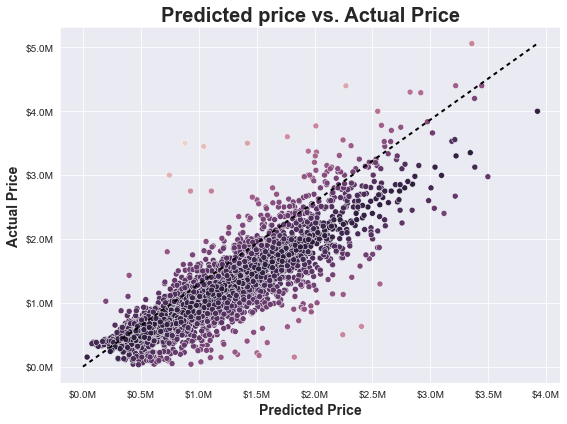

In [30]:
y_hat = lr.predict(X_test)

y_df = pd.DataFrame({'hat':y_hat.flatten()}, index=range(y_hat.shape[0]))
y_df['actual'] = y_test['price'].to_list()
y_df['resid'] = y_df['hat'] - y_df['actual']

fig, ax = plt.subplots(figsize=(8,6))
# sns.jointplot(x= 'actual',y= 'resid', data=y_df).set()
sns.scatterplot(x='hat',y='actual', data=y_df, hue=-np.abs(y_df['resid']))
ax.legend([],[], frameon=False)
plt.xlabel('Predicted Price', fontdict={'fontsize':14,
                                        'fontweight':'bold'})
plt.ylabel('Actual Price', fontdict={'fontsize':14,
                                     'fontweight':'bold'})
plt.title('Predicted price vs. Actual Price', fontdict={'fontsize':20,
                                                        'fontweight':'bold'})
formatter = ticker.FuncFormatter(lambda x, pos: '$%1.1fM' % (x * 1e-6))
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(formatter)
plt.plot([0, y_df['hat'].max()], [0, y_df['actual'].max()], linewidth=2, color='black', dashes=[2,2])
plt.tight_layout()

# plt.savefig('imgs/final_resid.png')
plt.show()

# Final Recommendations
With a Decent predictor for price, we can interpret the coeficients of the model to approximate the increase in Housing sale price for each unit increase of a feature  
To do so we inverse standard scale transform the coeficients.  
We will be disconsidering zipcode coeficients as one cannot renovate a zipcode.

In [31]:
# features excluding zipcodes
feat_names = X.columns.to_list()[:68]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    coefs = pd.DataFrame(columns=['feature','abs_coef_'])

    # take feature coeficients from linear model
    coefs['coef_'] = lr.coef_.flatten()[:68]
    coefs['feature'] = feat_names

    # inverse Standard SCale the coeficients
    price_increments = []
    for i, (col, coef) in enumerate(zip(feat_names,coefs['coef_'])):
        if col in p_mean.index.to_list():
            price_increments.append((coef - poly_means[col])/poly_std[col])
        else:
            price_increments.append(coef)
    coefs['price_increments'] = price_increments

    # bring in pvalue per coeficient to analyze significance
    coefs['pval'] = results.pvalues.to_list()[1:69]

    # create abs(coeficient) column for sorting dataframe 
    coefs['abs_coef_'] = np.abs(coefs['coef_'])
    coefs = coefs.sort_values(by='abs_coef_', ascending=False)

    exclude_zips = ['x2' not in feat for feat in coefs['feature']]
    display(coefs.loc[exclude_zips])

,feature,abs_coef_,coef_,price_increments,pval
9,nuisance,1.893438e+06,-1.893438e+06,-1.893438e+06,1.146552e-13
0,bedrooms,4.161658e+05,4.161658e+05,5.043986e+05,3.330104e-44
8,greenbelt,1.588871e+05,1.588871e+05,1.588871e+05,3.628352e-195
12,grade,8.026283e+04,8.026283e+04,8.132733e+04,2.006261e-94
5,yr_renovated,6.819778e+04,6.819778e+04,1.691012e+02,4.818921e-55
2,sqft_lot,5.331506e+04,-5.331506e+04,-1.682950e+01,1.280502e-19
11,condition,5.134239e+04,5.134239e+04,7.296362e+04,2.055618e-45
1,bathrooms,4.999748e+04,4.999748e+04,6.443909e+04,2.903502e-04
7,waterfront,4.889266e+04,4.889266e+04,4.889266e+04,7.704450e-20
4,yr_built,2.436282e+04,2.436282e+04,6.952279e+02,1.623766e-10


### Vizualizing Home Sale Price increment per relevant features

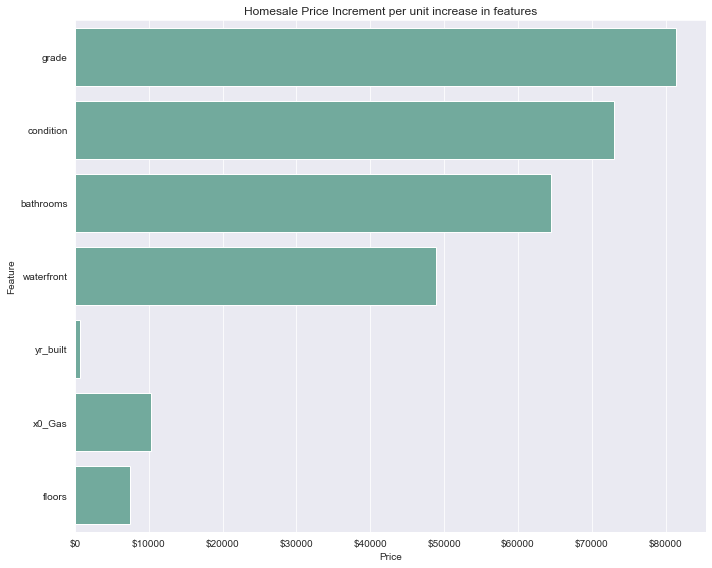

In [32]:
# Set the figure size
fig, ax = plt.subplots(figsize=(10, 8))
# bar
data = coefs.loc[(coefs['feature'] == 'waterfront') | \
                 (coefs['feature'] == 'grade') | \
                 (coefs['feature'] == 'condition') | \
                 (coefs['feature'] == 'bathrooms') | \
                 (coefs['feature'] == 'x0_Gas') | \
                 (coefs['feature'] == 'floors') | \
                 (coefs['feature'] == 'yr_built')]
sns.barplot(
    x="price_increments", 
    y="feature", 
    data=data, 
    color='#69b3a2',
    ax = ax
)
formatter = ticker.FuncFormatter(lambda x, pos: '$%1.0f' % (x))
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('Price')
ax.set_ylabel('Feature')
ax.set_title("Homesale Price Increment per unit increase in features")

plt.tight_layout()
plt.savefig('imgs/PriceIncrements.png')
plt.show()

# Pipeline model

IMPORTS

In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
import sklearn.linear_model as lm
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler,OneHotEncoder,OrdinalEncoder,
                                  PolynomialFeatures, PowerTransformer,
                                  FunctionTransformer)
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from itertools import chain, combinations
import warnings
warnings.filterwarnings(action='ignore')
sns.set_style('darkgrid')

%matplotlib inline

DATA

In [137]:
df = pd.read_csv('data/kc_house_data.csv', index_col=0) # (30155,25), 3 duplicated entries
print(f"Duplicates found and removed: * {df.loc[df.duplicated()].shape[0]} *")
df.drop_duplicates(inplace=True)

Duplicates found and removed: * 3 *


### Data Leakage-free transformations
 - Remove invalid addresses  
 - Define 'age' and 'renovated_delta' features,   
 - remove restricted sewer tags,   
 - drop grade == 1, combine grade == 4,5,6  
 - powerTransform price  


In [138]:
ci_zips = ['98002 (Auburn)', '98092 (Auburn)', '98224 (Baring)', '98004 (Bellevue)', '98005 (Bellevue)', '98006 (Bellevue)', '98007 (Bellevue)', '98008 (Bellevue)', '98010 (Black Diamond)', '98011 (Bothell)', '98178 (Bryn Mawr-Skyway)', '98148 (Burien)', '98166 (Burien)', '98014 (Carnation)', '98077 (Cottage Lake)', '98042 (Covington)', '98198 (Des Moines)', '98019 (Duvall)', '98031 (East Hill-Meridian)', '98022 (Enumclaw)', '98058 (Fairwood)', '98024 (Fall City)', '98003 (Federal Way)', '98023 (Federal Way)', '98027 (Issaquah)', '98029 (Issaquah)', '98028 (Kenmore)', '98032 (Kent)', '98030 (Kent)', '98033 (Kirkland)', '98034 (Kirkland)', '98001 (Lakeland North)', '98038 (Maple Valley)', '98039 (Medina)', '98040 (Mercer Island)', '98045 (North Bend)', '98047 (Pacific)', '98050 (Preston)', '98051 (Ravensdale)', '98052 (Redmond)', '98055 (Renton)', '98056 (Renton)', '98057 (Renton)', '98059 (Renton)', '98074 (Sammamish)', '98075 (Sammamish)', '98188 (SeaTac)', '98199 (Seattle)', '98174 (Seattle)', '98154 (Seattle)', '98158 (Seattle)', '98164 (Seattle)', '98101 (Seattle)', '98102 (Seattle)', '98103 (Seattle)', '98104 (Seattle)', '98105 (Seattle)', '98106 (Seattle)', '98107 (Seattle)', '98108 (Seattle)', '98109 (Seattle)', '98112 (Seattle)', '98115 (Seattle)', '98116 (Seattle)', '98117 (Seattle)', '98118 (Seattle)', '98119 (Seattle)', '98121 (Seattle)', '98122 (Seattle)', '98125 (Seattle)', '98126 (Seattle)', '98133 (Seattle)', '98134 (Seattle)', '98136 (Seattle)', '98144 (Seattle)', '98155 (Shoreline)', '98177 (Shoreline)', '98288 (Skykomish)', '98065 (Snoqualmie)', '98168 (Tukwila)', '98053 (Union Hill-Novelty Hill)', '98195 (Univ Of Washington)', '98070 (Vashon)', '98146 (White Center)', '98072 (Woodinville)']
ci_zips = set([x.split()[0] for x in ci_zips])

# strip zipcode from address and populate new columns 'zipcode', if zipcode not in King county, set to nan
def get_zipcodes(addr):
    zipcodes = []
    for i in range(addr.shape[0]):
        if addr.iloc[i] is np.nan:
            zipcodes.append('missing')
            continue
        zipcode = addr.iloc[i].split(',')[-2][-5:]
        zipcodes.append(zipcode if zipcode in ci_zips else np.nan)
    return zipcodes

df['zipcode'] = get_zipcodes(df.address)
df = df.loc[df.zipcode.notna()]

# Define yr_sold
df['yr_sold'] = df['date'].map(lambda x: int(x.split('/')[-1]))
# Define yr_built
df['age'] = df['yr_sold'] - df['yr_built']
# Define yr_renovated
def get_renovated_delta(x):
    # return years since last renovated
    yr_renovated_cleaned = []
    for i in range(x.shape[0]):
        row = x.iloc[i]
        if row['yr_renovated'] != 0:
            yr_renovated_cleaned.append(row['yr_sold'] - row['yr_renovated'])
        else:
            yr_renovated_cleaned.append(row['age'])
    return pd.Series(yr_renovated_cleaned, index=x.index)
df['renovated_delta'] = get_renovated_delta(df[['yr_sold','yr_renovated','age']])

# remove restricted tag from sewer system
df['sewer_system'] = df['sewer_system'].map(lambda x: x if (x is np.nan or x.split()[-1] != 'RESTRICTED') else x.split()[0])
# drop grade == 1, combine 456, and set range [0-10]
df['grade'] = df.loc[df.grade != '1 Cabin']['grade'].map(lambda x: int(x.split()[0])).replace({5:4,6:4}) - 2

# power transform price
df['price'] = PowerTransformer().fit_transform(df[['price']])

### Train Test Split

In [139]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['price']),df['price'],random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21891, 27), (7297, 27), (21891,), (7297,))

In [128]:
class IQR_Sampler(BaseEstimator, TransformerMixin):
    
    def __init__(self, IQR_factor = 1.5):
        super().__init__()
        self.IQR_factor = 1.5
        self.Q3 = {}
        self.Q1 = {}
        self.IQR = {}
        self.fitted = False
    
    def fit(self,X,y=None):
        for col in X.columns:
            self.Q3[col] = X[col].quantile(.75)
            self.Q1[col] = X[col].quantile(.25)
            self.IQR[col] = self.Q3[col] - self.Q1[col]
        self.fitted = True
        return self
        
    def transform(self,X,y=None):
        if not self.fitted:
            raise Exception('Cannot transfor before fit')
        keep = set(list(X.index))
        for col in X.columns:
            upper_bound = self.Q3[col] + self.IQR[col]
            lower_bound = self.Q1[col] - self.IQR[col]
            keep = keep and set(list(X[col][(X[col] <= upper_bound) & (X[col] >= lower_bound)].index))
        print('out',X.loc[keep].shape)
        return X.loc[keep]
    
    def fit_transform(self,X,y=None):
        print('in',X.shape)
        return self.fit(X,y).transform(X,y)

# cols
num_cols = ['renovated_delta', 'age', 'bedrooms', 'bathrooms', 'sqft_living', 
            'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'sqft_garage', 
            'sqft_patio']
ohe_cols = ['zipcode','heat_source','sewer_system','grade']
oe_cols = ['waterfront', 'greenbelt', 'nuisance', 
           'view', 'condition']

iqr_sampler = IQR_Sampler()
print('train_size before:',X_train.shape)
print('test_size before:',X_train.shape)
X_train = iqr_sampler.fit_transform(X_train[num_cols]).join(X_train[list(set(oe_cols) | set(ohe_cols))])
y_train = y_train.loc[X_train.index]
X_test = iqr_sampler.transform(X_test[num_cols]).join(X_test[list(set(oe_cols) | set(ohe_cols))])
y_test = y_test.loc[X_test.index]
print('train_size after:',X_train.shape)
print('test_size after:',X_train.shape)
print('test_size =', X_test.shape[0]/(X_test.shape[0] + X_train.shape[0]))

train_size before: (21891, 27)
test_size before: (21891, 27)
in (21891, 11)
out (20221, 11)
out (6722, 11)
train_size after: (20221, 20)
test_size after: (20221, 20)
test_size = 0.2494896633633968


Plan  
Pre-ttsplit:
 - [address] -> [zipcode]
 - [date] -> [yr_sold]

Num_Pipe
 - SimpleImputer median [yr_sold,yr_built,yr_renovated,bedrooms,bathrooms,sqft*,floors]
 - CT (passthrough) 
    - [yr_sold,yr_built] -> [yr_built]
    - [yr_renovated, yr_built, yr_sold] -> [yr_renovated]
 - Remove outliers from [bedrooms,bathrooms,sqft*,floors,yr_build,yr_renovated]
 - standard scale [bedrooms,bathrooms,sqft*,floors,yr_build,yr_renovated]
 - poly trans [bedrooms,bathrooms,sqft*,floors,yr_build,yr_renovated]
 - (standard scale [bedrooms,bathrooms,sqft*,floors,yr_build,yr_renovated])
 - (PCA [bedrooms,bathrooms,sqft*,floors,yr_build,yr_renovated])
 - (standard scale [bedrooms,bathrooms,sqft*,floors,yr_build,yr_renovated])  
 
Cat_CT
 - nan restricteds [sewer_system]
 - impute mode ['heat_source', 'sewer_system']
 - OrdinalEncoder [waterfront,greenbelt,nuisance,view,condition,grade,heatsource]
 - OneHotEncode [zip]
 - (standard scale [waterfront,greenbelt,nuisance,view,condition,grade,heatsource,zip])  

Pipeline
 - FeatUnion(Num_CT, Cat_CT)
 - PCA [all*]


In [143]:
# Define the column transformer for preprocessing the features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols), # Impute median, StandardScaler, and PolynomialFeatures for numeric features
        ('ohe', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore',sparse=False,drop='first'))
        ]), ohe_cols), # Impute mode and OneHotEncoder for categorical feature 1
        ('oe', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ordinal', OrdinalEncoder(categories=[['NO','YES'],
                                                   ['NO','YES'],
                                                   ['NO','YES'],
                                                   ['NONE','AVERAGE','FAIR','GOOD','EXCELLENT'],
                                                   ['Poor','Average','Fair','Good','Very Good']
                                                   ])),
            ('scaler', StandardScaler())
        ]), oe_cols), # Impute mode and OrdinalEncoder for categorical feature 2
    ])

# Define the pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('pca', PCA(n_components='mle',random_state=42)),
    ('regressor', LinearRegression())
])

# Fit the pipeline on the data
pipe.fit(X_train, y_train)

# Predict using the pipeline
pipe.score(X_test,y_test)

0.5958821037909697